# Máster en Data Science - Machine Learning

# Procesamiento de variables: Codificación de variables categóricas y escalado
Autor: Ramón Morillo Barrera

## Dataset: Application data

Voy a llevar un experimento a cabo con el modelo que mejores resultados me dió. Analizando las variables más importantes observamos en clase que las variables EXT_SOURCE_2 y EXT_SOURCE_3 tenían una gran importancia relativa en nuestro modelo, pero vimos que la correlación con la variable objetivo no era muy alta.

Es por ello que voy a analizar los resultados de mi modelo sobre 4 sets de datos.
- El set completo
- Mi set procesado
- El set completo sin las variables EXT_SOURCE
- Mi set procesado sin las variables EXT_SOURCE

Al final de este análisis daré mis conclusiones

### Librerías

In [2]:
import sys
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, fbeta_score, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix, calinski_harabasz_score, silhouette_samples

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.svm import SVC, LinearSVC, NuSVC
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
from joblib import dump, load
from sklearn.feature_selection import SelectFromModel, RFE
import lightgbm as lgb

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Funciones

In [3]:
sys.path.append('../src')
import funciones_auxiliares as f_aux
sys.path.remove('../src')

seed = 12354

***

## Set completo

In [4]:
df_loan_train = pd.read_csv("../../data_loan_status/interim/data_split/df_loan_train.csv")
df_loan_test = pd.read_csv("../../data_loan_status/interim/data_split/df_loan_test.csv")

In [5]:
y_train = df_loan_train['TARGET']
X_train = df_loan_train.drop('TARGET', axis=1)
y_test = df_loan_test['TARGET']
X_test = df_loan_test.drop('TARGET', axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((246008, 121), (246008,), (61503, 121), (61503,))

In [6]:
X_train_scaled = pd.read_csv("../../data_loan_status/interim/X_train_scaled.csv")
X_test_scaled = pd.read_csv("../../data_loan_status/interim/X_test_scaled.csv")

X_train_scaled.shape, X_test_scaled.shape

((246008, 175), (61503, 175))

## Set procesado

In [7]:
df_loan_train_processed = pd.read_csv("../../data_loan_status/processed/df_loan_train_processed.csv")
df_loan_test_processed = pd.read_csv("../../data_loan_status/processed/df_loan_test_processed.csv")

In [8]:
y_train_processed = df_loan_train_processed['TARGET']
X_train_processed = df_loan_train_processed.drop('TARGET', axis=1)
y_test_processed = df_loan_test_processed['TARGET']
X_test_processed = df_loan_test_processed.drop('TARGET', axis=1)

X_train_processed.shape, y_train_processed.shape, X_test_processed.shape, y_test_processed.shape

((246008, 21), (246008,), (61503, 21), (61503,))

## Set completo sin Ext source

In [9]:
X_train_scaled_sin = X_train_scaled.drop(columns=['EXT_SOURCE_2', 'EXT_SOURCE_3'])
X_test_scaled_sin = X_test_scaled.drop(columns=['EXT_SOURCE_2', 'EXT_SOURCE_3'])

X_train_scaled_sin.shape, X_test_scaled_sin.shape

((246008, 173), (61503, 173))

## Set procesado sin Ext source

In [10]:
X_train_processed_sin = X_train_processed.drop(columns=['EXT_SOURCE_2', 'EXT_SOURCE_3'])
X_test_processed_sin = X_test_processed.drop(columns=['EXT_SOURCE_2', 'EXT_SOURCE_3'])

X_train_processed_sin.shape, X_test_processed_sin.shape

((246008, 19), (61503, 19))

***

Haré pruebas con 4 datasets:
- Dataset completo (X_train_scaled, X_test_scaled, y_train, y_test)
- Dataset procesado (X_train_processed, X_test_processed, y_train_processed, y_test_processed)
- Dataset completo sin ext source
- Dataset procesado sin ext source

In [11]:
lgbm = lgb.LGBMClassifier(verbosity=-1)
datasets_train = [[X_train_scaled, y_train]\
                 ,[X_train_processed, y_train_processed]\
                 ,[X_train_scaled_sin, y_train]\
                 ,[X_train_processed_sin, y_train_processed]\
                 ]

# Remove special characters from feature names
X_train_scaled.columns = X_train_scaled.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test_scaled.columns = X_test_scaled.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_train_processed.columns = X_train_processed.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test_processed.columns = X_test_processed.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_train_scaled_sin.columns = X_train_scaled_sin.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test_scaled_sin.columns = X_test_scaled_sin.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_train_processed_sin.columns = X_train_processed_sin.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test_processed_sin.columns = X_test_processed_sin.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

datasets_validation = [[X_test_scaled, y_test]\
                      ,[X_test_processed, y_test_processed]\
                      ,[X_test_scaled_sin, y_test]\
                      ,[X_test_processed_sin, y_test_processed]\
                       ]

names = ['Set completo', 'Set procesado', 'Set completo sin ext source', 'Set procesado sin ext source']

for train, val, name in zip(datasets_train, datasets_validation, names):
    lgbm.fit(train[0], train[1])   
    y_pred_lgbm = lgbm.predict(val[0])
    print(f'\033[1m{name}\033[0m')
    f_aux.summarize_metrics(val[1], y_pred_lgbm)
    print("-------------------------------------------------------------------------------")

Set completo
Accuracy: 0.91945
Balanced Accuracy: 0.50487
F2 Score: 0.01303
F1 Score: 0.02056
Precision: 0.55914
Recall: 0.01047

Confusion Matrix:
[[56497    41]
 [ 4913    52]]
-------------------------------------------------------------------------------
Set procesado
Accuracy: 0.91935
Balanced Accuracy: 0.50280
F2 Score: 0.00753
F1 Score: 0.01195
Precision: 0.54545
Recall: 0.00604

Confusion Matrix:
[[56513    25]
 [ 4935    30]]
-------------------------------------------------------------------------------
Set completo sin ext source
Accuracy: 0.91930
Balanced Accuracy: 0.50075
F2 Score: 0.00201
F1 Score: 0.00321
Precision: 0.57143
Recall: 0.00161

Confusion Matrix:
[[56532     6]
 [ 4957     8]]
-------------------------------------------------------------------------------
Set procesado sin ext source
Accuracy: 0.91926
Balanced Accuracy: 0.50017
F2 Score: 0.00050
F1 Score: 0.00080
Precision: 0.40000
Recall: 0.00040

Confusion Matrix:
[[56535     3]
 [ 4963     2]]
------------

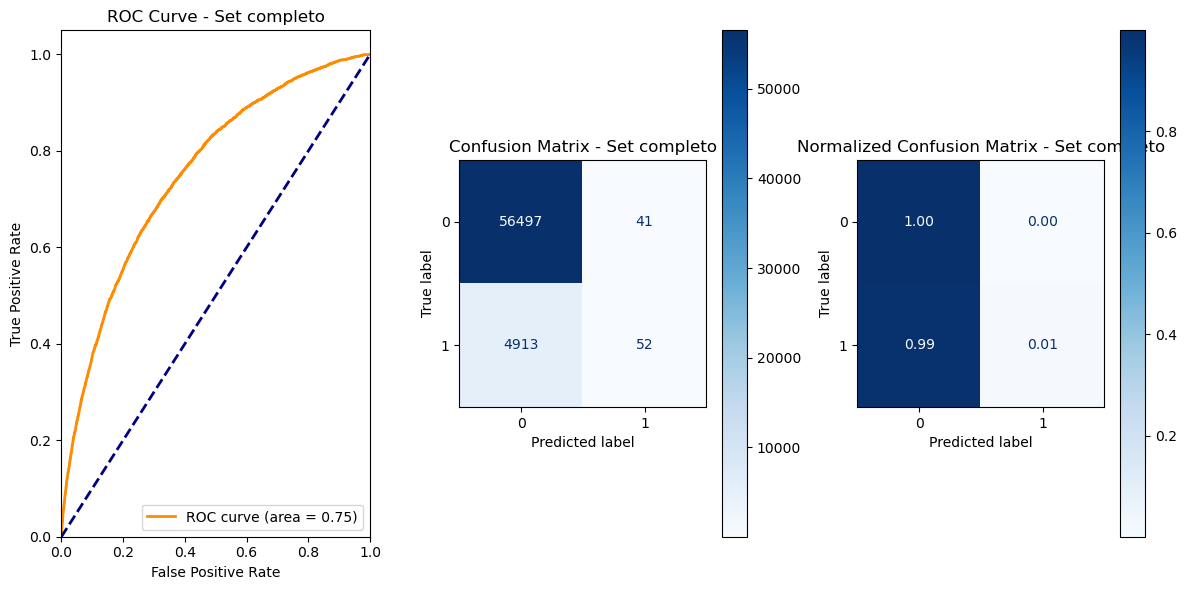

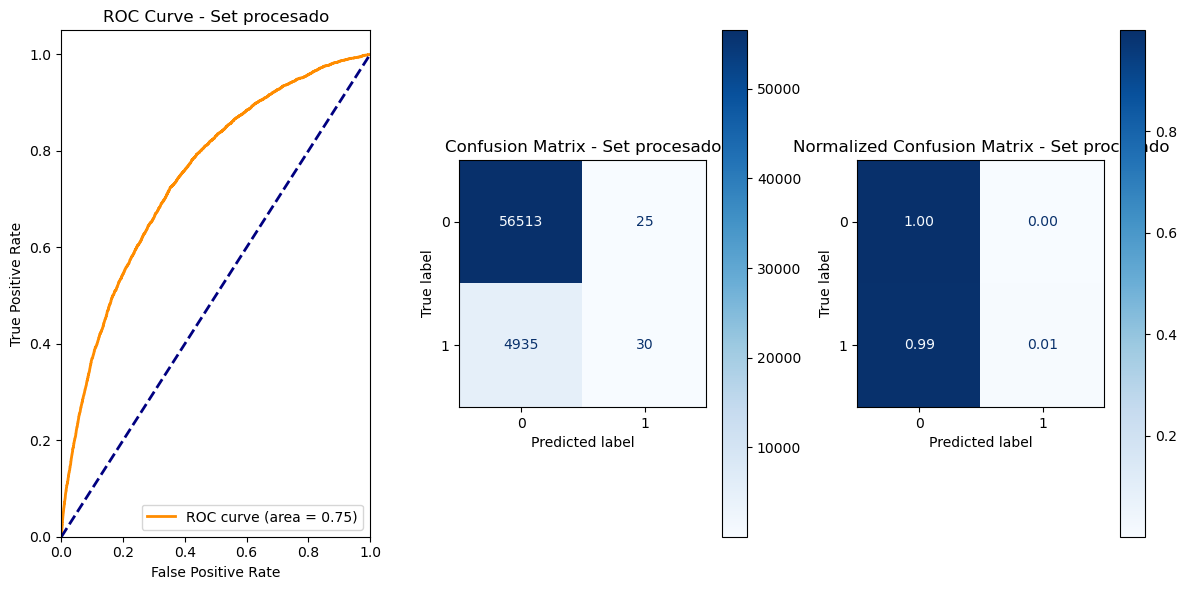

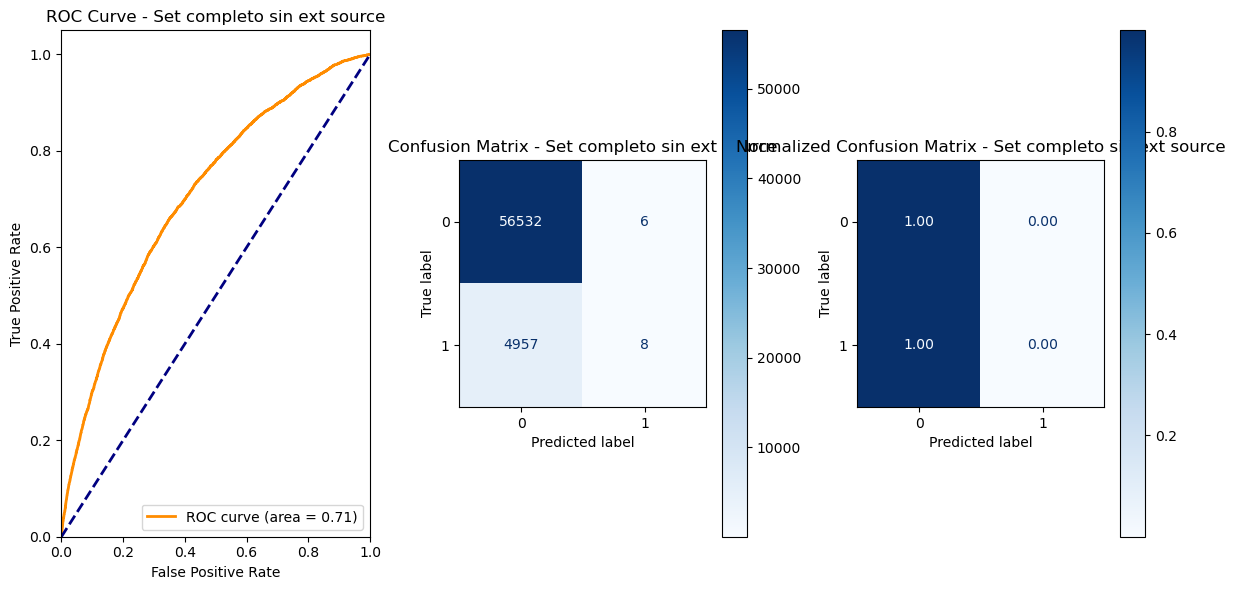

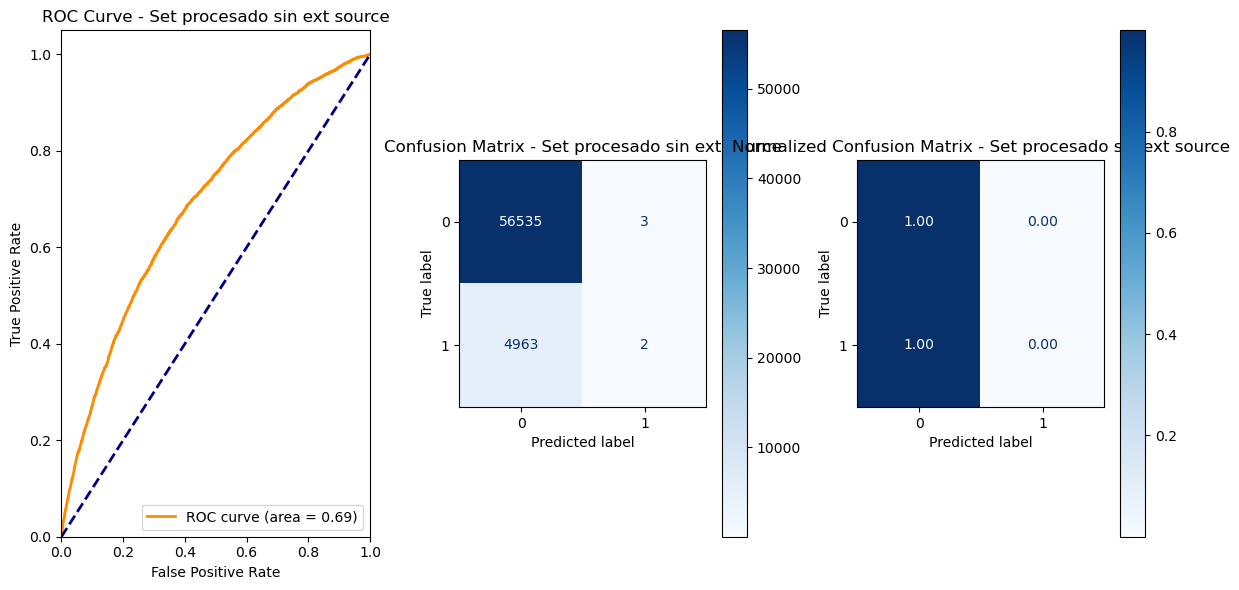

In [12]:
# Función para plotear la curva ROC y las matrices de confusión
def plot_metrics(y_true, y_pred_proba, model_name):
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(12, 6))
    
    # Subplot para la curva ROC
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    
    # Matriz de confusión absoluta
    y_pred = (y_pred_proba >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 3, 2)
    ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Matriz de confusión normalizada
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 3, 3)
    ConfusionMatrixDisplay(cm_normalized).plot(ax=plt.gca(), cmap='Blues', values_format='.2f')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    
    plt.tight_layout()
    plt.show()

# Iterar sobre los datasets y modelos
for train, val, name in zip(datasets_train, datasets_validation, names):
    lgbm.fit(train[0], train[1])   
    y_pred_proba_lgbm = lgbm.predict_proba(val[0])[:, 1]
    plot_metrics(val[1], y_pred_proba_lgbm, name)

Como podemos observar, los sets sin las variables EXT_SOURCE proporcionan resultados bastante pobres, esto es porque las variables si que son importantes y proporcionan bastante información al modelo, lejos de sesgarlo. Es por ello que continuaré con el análisis del set completo que, a priori es el que mejores resultados proporciona.

Al final de este notebook decidiré si realizar el análisis final de mi modelo con el dataset completo o reduciendo las variables como hasta ahora he hecho.

He de comentar que a priori los resultados con las 175 variables no son notablemente mejores que con las 21 variables que ya tenía seleccionadas. Veremos los resultados al final del notebook.

## Train-validation split
### Set completo

In [13]:
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(X_train_scaled, y_train
                                                  ,stratify=df_loan_train['TARGET']
                                                  ,test_size=0.2
                                                  ,random_state=seed)


print("Conjunto original:")
print(f"X_train_orig: {X_train_orig.shape}, y_train_orig: {y_train_orig.shape}")
print(f"X_val_orig: {X_val_orig.shape}, y_val_orig: {y_val_orig.shape}")

Conjunto original:
X_train_orig: (196806, 175), y_train_orig: (196806,)
X_val_orig: (49202, 175), y_val_orig: (49202,)


Accuracy: 0.70306
Balanced Accuracy: 0.68715
F2 Score: 0.41685
F1 Score: 0.26649
Precision: 0.16644
Recall: 0.66818

Confusion Matrix:
[[31938 13292]
 [ 1318  2654]]


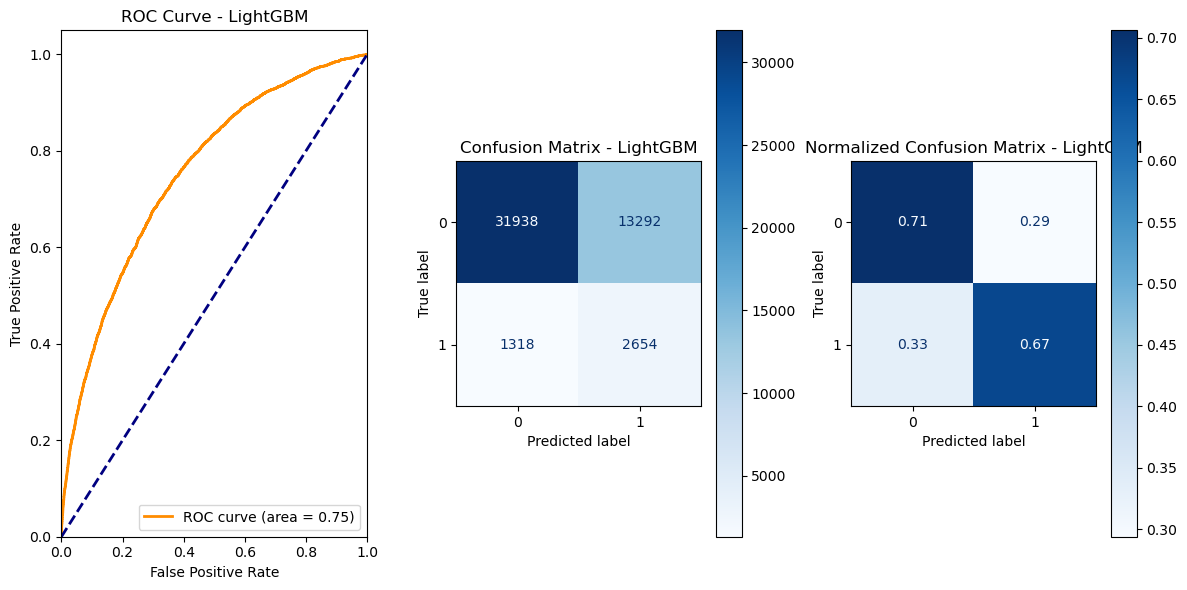

In [14]:
# Entrenar el modelo LightGBM
lgbm = lgb.LGBMClassifier(verbosity=-1, objective='binary', is_unbalance=True)
lgbm.fit(X_train_orig, y_train_orig)

# Predecir en el conjunto de validación
y_pred = lgbm.predict(X_val_orig)
y_pred_proba = lgbm.predict_proba(X_val_orig)[:, 1]

# Mostrar las métricas
f_aux.summarize_metrics(y_val_orig, y_pred)

# Mostrar la matriz de confusión absoluta y normalizada y la curva ROC con su AUC
plot_metrics(y_val_orig, y_pred_proba, "LightGBM")

### Set procesado

In [15]:
X_train_pro, X_val_pro, y_train_pro, y_val_pro = train_test_split(X_train_processed, y_train_processed
                                                  ,stratify=df_loan_train_processed['TARGET']
                                                  ,test_size=0.2
                                                  ,random_state=seed)


print("Conjunto original:")
print(f"X_train_orig: {X_train_pro.shape}, y_train_orig: {y_train_pro.shape}")
print(f"X_val_orig: {X_val_pro.shape}, y_val_orig: {y_val_pro.shape}")

Conjunto original:
X_train_orig: (196806, 21), y_train_orig: (196806,)
X_val_orig: (49202, 21), y_val_orig: (49202,)


Accuracy: 0.69853
Balanced Accuracy: 0.68503
F2 Score: 0.41434
F1 Score: 0.26376
Precision: 0.16427
Recall: 0.66893

Confusion Matrix:
[[31712 13518]
 [ 1315  2657]]


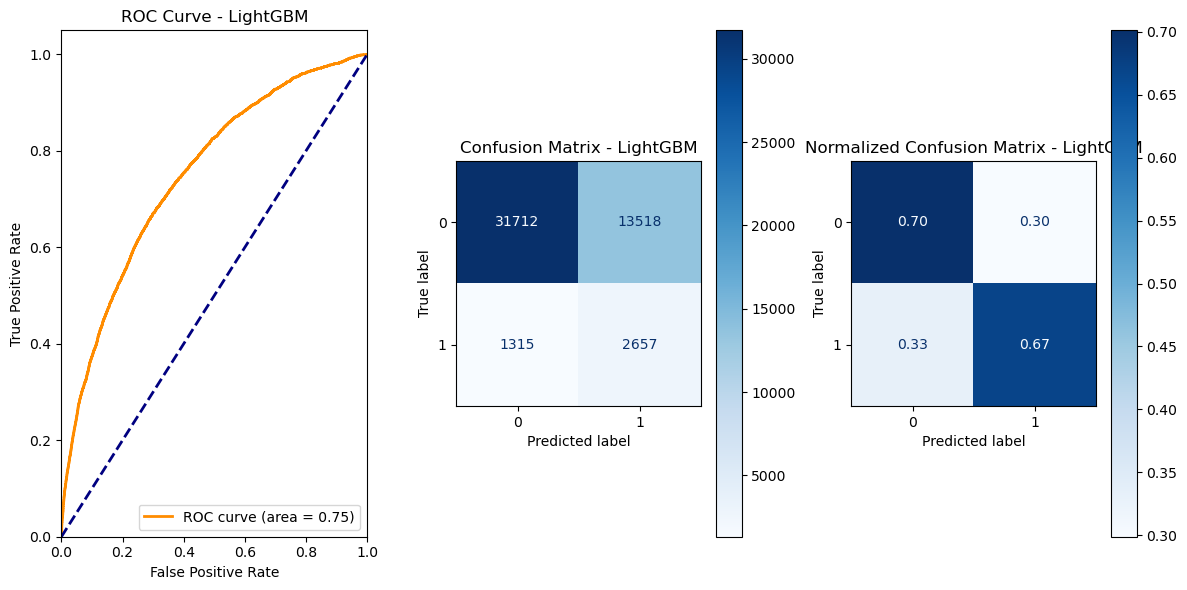

In [16]:
# Entrenar el modelo LightGBM
lgbm = lgb.LGBMClassifier(verbosity=-1, objective='binary', is_unbalance=True)
lgbm.fit(X_train_pro, y_train_pro)

# Predecir en el conjunto de validación
y_pred_2 = lgbm.predict(X_val_pro)
y_pred_proba_2 = lgbm.predict_proba(X_val_pro)[:, 1]

# Mostrar las métricas
f_aux.summarize_metrics(y_val_pro, y_pred_2)

# Mostrar la matriz de confusión absoluta y normalizada y la curva ROC con su AUC
plot_metrics(y_val_pro, y_pred_proba_2, "LightGBM")

Parece ser que con el set completo los resultados son ligeramente mejores. Voy a ajustar hiperparámetros y probarlo con el dataset de test.

***

## Ajuste de hiperparámetros

In [18]:
f2_scorer = make_scorer(fbeta_score, beta=2)

lgbm = lgb.LGBMClassifier(verbosity=-1, objetive='binary', is_unbalance=True)
param_grid = { 
    'max_depth' : np.random.randint(3,10,10)
    ,'num_leaves' : np.random.randint(round(2**3/1.5),round(2**10/1.5),20) # En a documentación de LightGBM se especifica que num_leaves se relaciona con el max_depth así: (num_leaves = (2^max_depth/1.5))
    ,'min_data_in_leaf' : np.random.randint(1000,2000,20)
    ,'n_estimators ': np.random.randint(100,700,10)
    ,'learning_rate': np.random.uniform(0.01, 0.05,10)
    ,'subsample': np.random.uniform(0.8,1,10)
    ,'colsample_bytree': np.random.uniform(0.8,1,10)
    ,'min_child_samples': np.random.randint(20,500,20)
}

scoring = {'f2':f2_scorer,'f1':'f1','accuracy':'accuracy', 'balanced_accuracy':'balanced_accuracy', 'precision':'precision', 'recall':'recall','roc_auc':'roc_auc'}

CV_rs2 = RandomizedSearchCV(lgbm, param_grid, n_iter=50, cv=10, random_state=seed, n_jobs=-1, scoring=scoring, refit='f2')

CV_rs2.fit(X_train_orig, y_train_orig)  
print(CV_rs2.best_params_)    
print(CV_rs2.best_score_)

{'subsample': np.float64(0.8735651454685351), 'num_leaves': np.int32(58), 'n_estimators ': np.int32(379), 'min_data_in_leaf': np.int32(1221), 'min_child_samples': np.int32(180), 'max_depth': np.int32(8), 'learning_rate': np.float64(0.0498701550516601), 'colsample_bytree': np.float64(0.834746708397489)}
0.42075915171405354


In [22]:
lgbm = lgb.LGBMClassifier(num_leaves=58
                      ,n_estimators=379
                      ,min_data_in_leaf=1221
                      ,max_depth= 8 # disminuyo este valor para evitar overfitting y mejorar el rendimiento
                      ,learning_rate=0.0498701550516601
                      ,subsample=0.8735651454685351 # corrected value
                      ,min_child_samples=180
                      ,colsample_bytree=0.834746708397489
                      ,verbosity=-1)

lgbm.fit(X_train_orig, y_train_orig)

y_pred = lgbm.predict(X_test_scaled)

f_aux.summarize_metrics(y_test, y_pred)

Accuracy: 0.91968
Balanced Accuracy: 0.50518
F2 Score: 0.01354
F1 Score: 0.02139
Precision: 0.65060
Recall: 0.01088

Confusion Matrix:
[[56509    29]
 [ 4911    54]]


In [23]:
y_pred_proba3 = lgbm.predict_proba(X_test_scaled)
y_pred_proba3

array([[0.85485413, 0.14514587],
       [0.98951698, 0.01048302],
       [0.80185794, 0.19814206],
       ...,
       [0.98604634, 0.01395366],
       [0.92493465, 0.07506535],
       [0.98219678, 0.01780322]])

***

## Análisis de métricas

Best Threshold = 0.068187, G-Mean = 0.689

*************************************************************

El coeficiente de GINI es: 0.51

El área por debajo de la curva ROC es: 0.7564

*************************************************************


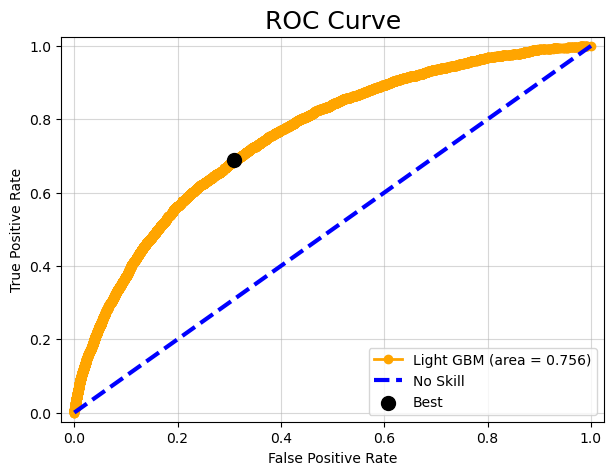

In [24]:
f_aux.roc_curve_plot_v2(y_test, y_pred_proba3[:,1], model_name='Light GBM', figsize=(7,5))
plt.show()

Best Threshold = 0.65295, F2 Score = nan, AUC = 0.2338


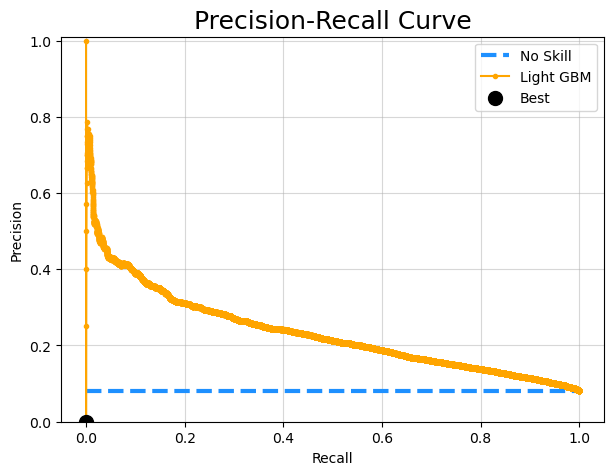

In [25]:
f_aux.pr_curve_plot(y_test, y_pred_proba3[:,1], f_score_beta=2, model_name='Light GBM', figsize=(7,5))

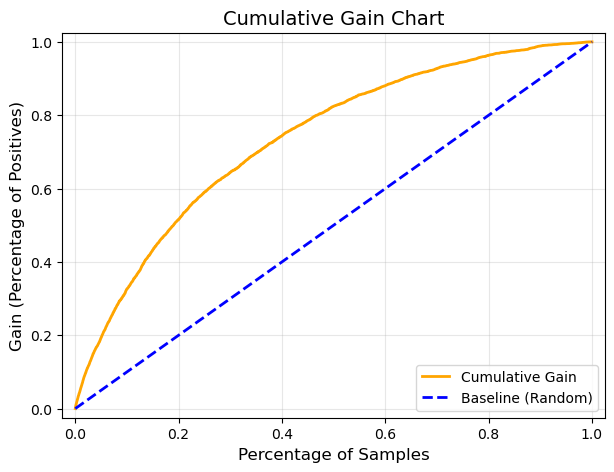

In [26]:
f_aux.plot_cumulative_gain(y_test, y_pred_proba3[:,1])

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of Sample', ylabel='Lift'>

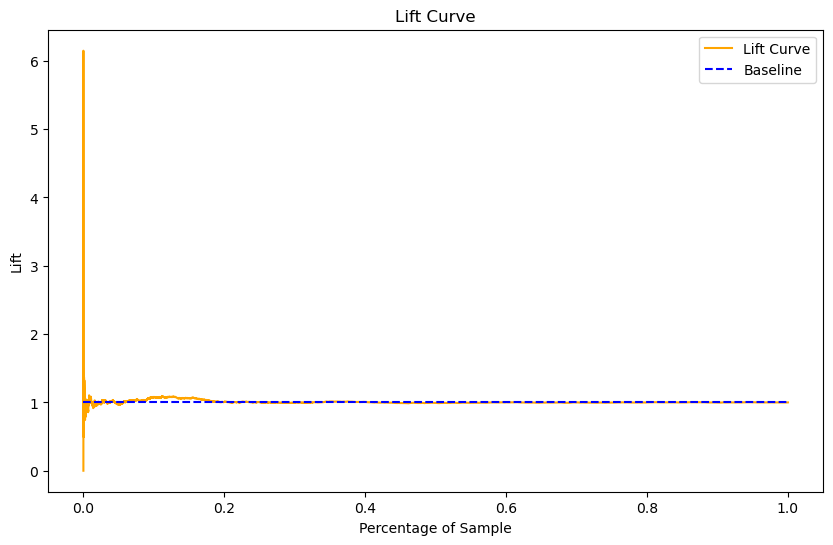

In [29]:
if y_pred_proba.ndim == 1:
    y_pred_proba = lgbm.predict_proba(X_val_orig)[:, 1]

f_aux.plot_lift_curve(y_test, y_pred_proba)


In [30]:
prob_predictions = y_pred_proba3[:,1]
recall_precision = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions]
    recall_precision.append([threshold, recall_score(y_test, given_threshold)
                            ,precision_score(y_test, given_threshold)
                            ,fbeta_score(y_test, given_threshold, beta=2)
                            ,f1_score(y_test, given_threshold)])

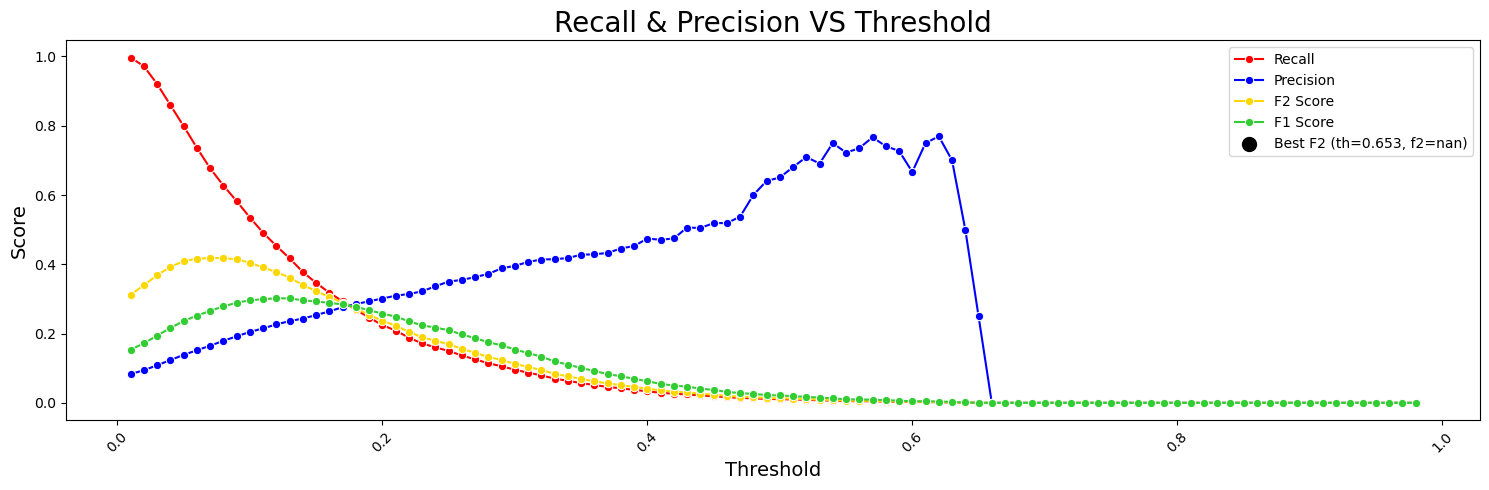

In [31]:
f_aux.plot_recall_precision(recall_precision, y_test, y_pred_proba3[:,1])

In [32]:
proba_tags = pd.concat([pd.Series(y_pred_proba3[:,1]),pd.Series(y_pred)],axis=1).rename(columns={0:'Probability', 1:'Default'})
proba_tags[proba_tags.Default == 1].Probability.describe()

count    83.000000
mean      0.560053
std       0.052098
min       0.500186
25%       0.519966
50%       0.543312
75%       0.591221
max       0.777653
Name: Probability, dtype: float64

In [33]:
y_pred_th_f2 = np.where(proba_tags.Probability>0.41,1,0) # Threshold que maximiza el F2
y_pred_th_roc = np.where(proba_tags.Probability>0.069,1,0) # Threshold óptimo de la curva ROC (mejor proporción promedio TP y FP). Alto Recall pero muchos FP.
y_pred_th_5fp = np.where(proba_tags.Probability>0.189,1,0) # Threshold ejemplo de caso de negocio en donde se aceptan max 5% de FP
proba_tags['Threshold F2'] = y_pred_th_f2
proba_tags['Threshold Roc'] = y_pred_th_roc
proba_tags['Threshold 5% FP'] = y_pred_th_5fp
proba_tags

,Probability,Default,Threshold F2,Threshold Roc,Threshold 5% FP
0,0.145146,0,0,1,0
1,0.010483,0,0,0,0
2,0.198142,0,0,1,1
3,0.017501,0,0,0,0
4,0.033343,0,0,0,0
...,...,...,...,...,...
61498,0.014372,0,0,0,0
61499,0.098310,0,0,1,0
61500,0.013954,0,0,0,0
61501,0.075065,0,0,1,0


In [35]:
print("\033[1mMáximizando el F2 --> Threshold 0.41:\033[0m")
f_aux.summarize_metrics(y_test, y_pred_th_f2)
print('__________________________________________\n')

print("\033[1mMejor proporción promedio TP y FP, óptimo curva ROC. Alto Recall pero muchos FP --> Threshold 0.069\033[0m")
f_aux.summarize_metrics(y_test, y_pred_th_roc)
print('__________________________________________\n')

print("\033[1mEjemplo de caso de negocio en donde se aceptan max 5% de FP --> Threshold 0.189:\033[0m")
f_aux.summarize_metrics(y_test, y_pred_th_5fp)

Máximizando el F2 --> Threshold 0.41:
Accuracy: 0.91898
Balanced Accuracy: 0.51316
F2 Score: 0.03595
F1 Score: 0.05500
Precision: 0.47078
Recall: 0.02920

Confusion Matrix:
[[56375   163]
 [ 4820   145]]
__________________________________________

Mejor proporción promedio TP y FP, óptimo curva ROC. Alto Recall pero muchos FP --> Threshold 0.069
Accuracy: 0.69341
Balanced Accuracy: 0.68893
F2 Score: 0.41861
F1 Score: 0.26470
Precision: 0.16413
Recall: 0.68359

Confusion Matrix:
[[39253 17285]
 [ 1571  3394]]
__________________________________________

Ejemplo de caso de negocio en donde se aceptan max 5% de FP --> Threshold 0.189:
Accuracy: 0.89069
Balanced Accuracy: 0.59772
F2 Score: 0.25598
F1 Score: 0.26836
Precision: 0.29190
Recall: 0.24834

Confusion Matrix:
[[53547  2991]
 [ 3732  1233]]


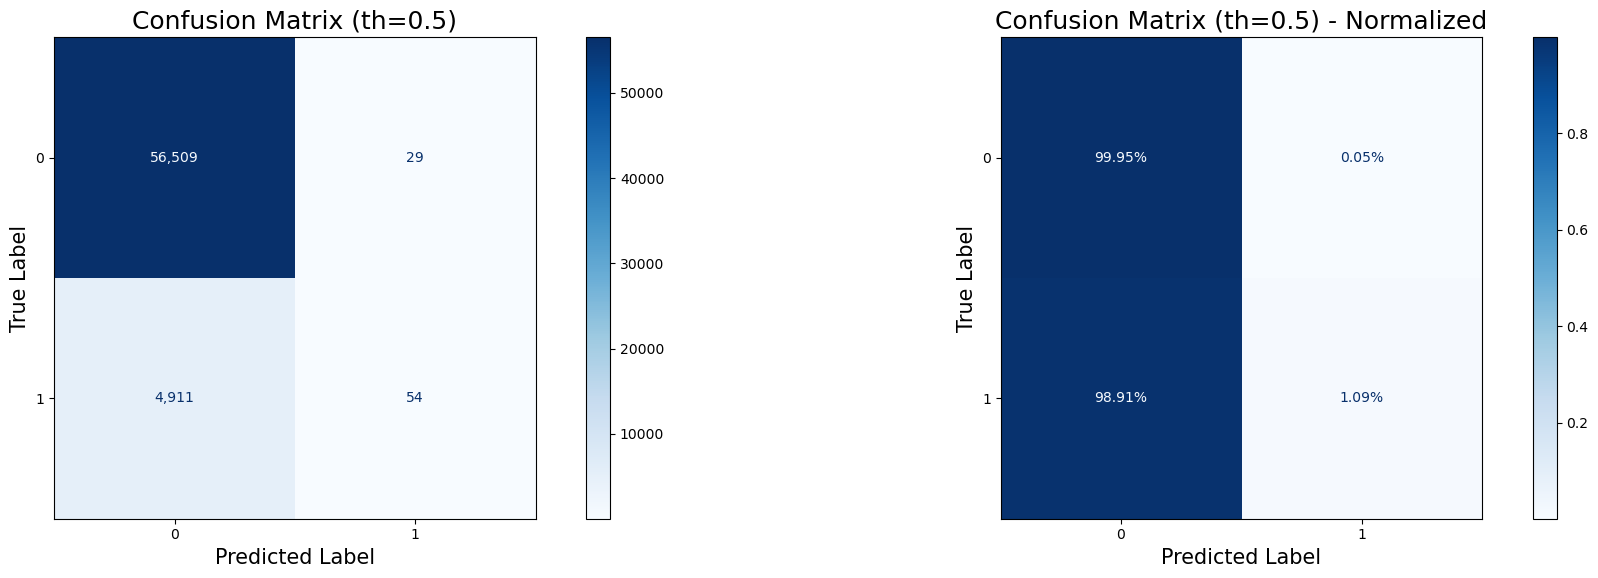

In [36]:
f_aux.plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix (th=0.5)')

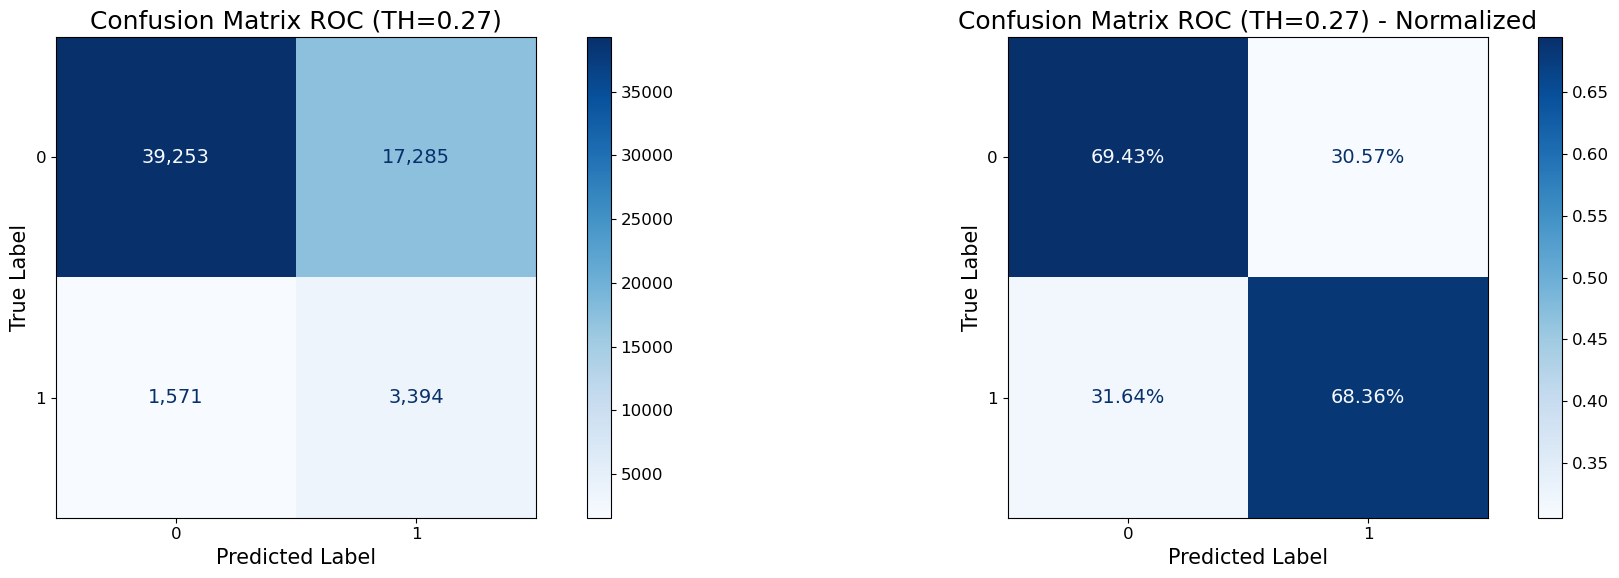

In [37]:
f_aux.plot_confusion_matrix(y_test, y_pred_th_roc, title='Confusion Matrix ROC (TH=0.27)')

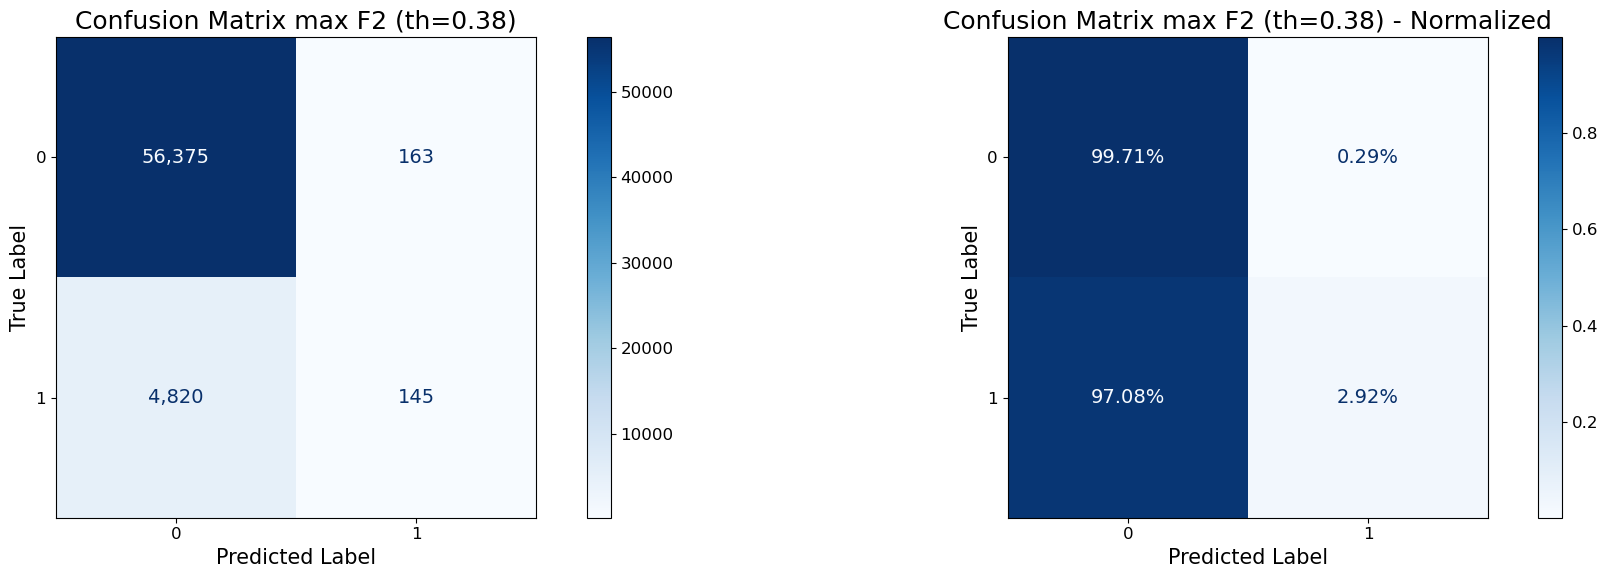

In [38]:
f_aux.plot_confusion_matrix(y_test, y_pred_th_f2, title='Confusion Matrix max F2 (th=0.38)')

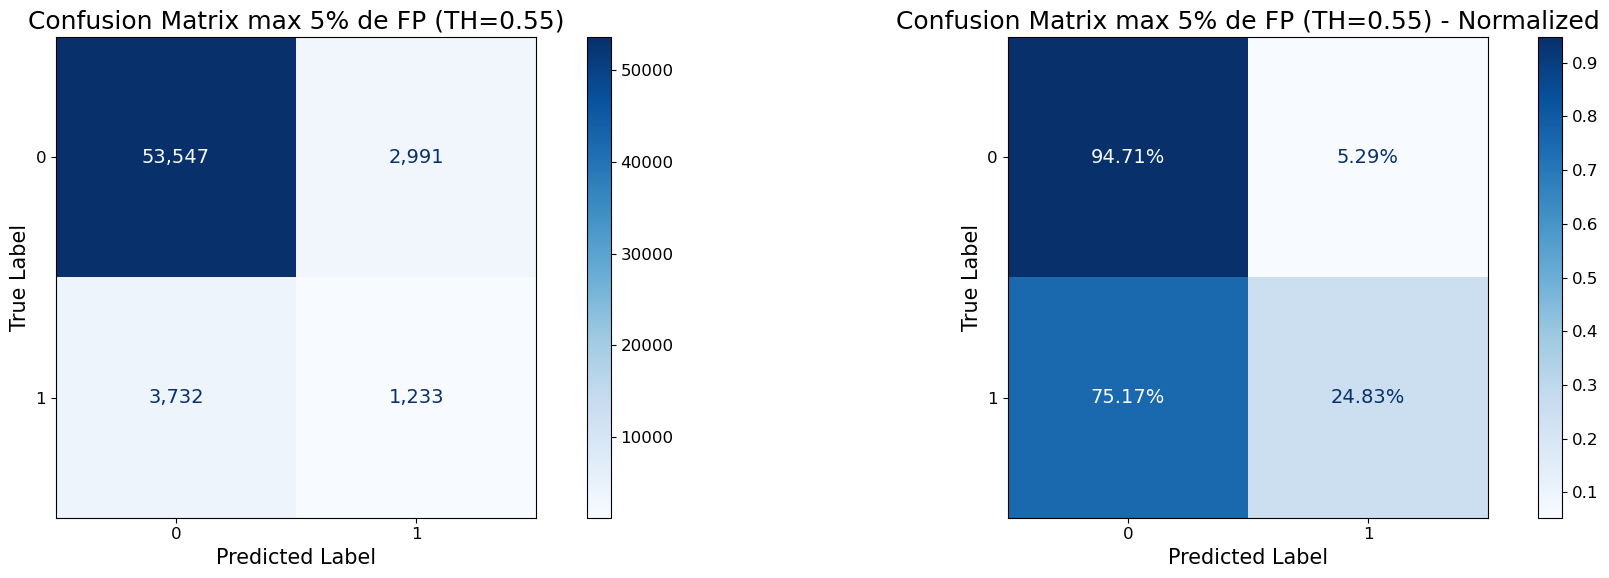

In [39]:
f_aux.plot_confusion_matrix(y_test, y_pred_th_5fp, title='Confusion Matrix max 5% de FP (TH=0.55)')

Como conclusión final, he de comentar que las pequeñas mejoras de los resultados aquí analizados con el dataset completo (175 variables) en comparación con nuestro dataset preprocesado (21 variables), no son notablemente mejores. Es por ello que ek coste computacional que esto supone no justifica la ampliación de las variables. Pues como he analizado en el anterior experimento, la explicabilidad del dataset no aumenta mucho cuando pasamos de 21 variables a 45, y por ende, en este notebook he demostrado que los resultados no mejoran demasiado con el dataset completo.

Es por lo que continuaré con mi modelo de clasificación LightGBM con las 21 variables que seleccioné anteriormente.